<center><b> In this notebook, I have tried my best to explain all the concepts of convolutional neural networks (CNN) with the help of illustrations and in-depth descriptions. </b></center>

<hr>

# Importing required libraries

The following libraries are imported at the beginning of the code:

- `numpy`: a library for numerical computing in Python
- `pandas`: a library for data manipulation and analysis
- `os`: a module for interacting with the operating system
- `matplotlib.pyplot`: a module for creating visualizations in Python



In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpu_name = tf.test.gpu_device_name()
if (gpu_name != ''):
    gpu_message = gpu_name  
    print("Testing with GPU: {}".format(gpu_message))
else:
    gpu_message = "ERROR <GPU NO AVAILABLE>"
    print("Testing with GPU: {}".format(gpu_message))

from tensorflow.python.client import device_lib
print(device_lib.list_local_de vices())

Num GPUs Available:  0
Testing with GPU: ERROR <GPU NO AVAILABLE>
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8739573184475615479
xla_global_id: -1
]



# Loading and Visualizing Data
In this section, we will be loading and visualizing the dataset. 
We will first use pandas to read the csv file



In [2]:
#First we read the training dataset
train = pd.read_csv("data/train.csv") 
train.head()
print(f"Shape of training dataset is: {train.shape}")

Shape of training dataset is: (42000, 785)


In [3]:
# Now we read testing dataset 
test = pd.read_csv("../input/digit-recognizer/test.csv") 
test.head()
print(f"Shape of testing dataset is: {test.shape}")

Shape of testing dataset is: (28000, 784)


In [4]:
#Now, we extract labels
Y_train = train["label"]
# Drop 'label' column so that we can directly extract training pixel values in the required format
train_temp=train.drop(labels = ["label"],axis = 1) 
X_train = train_temp.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]


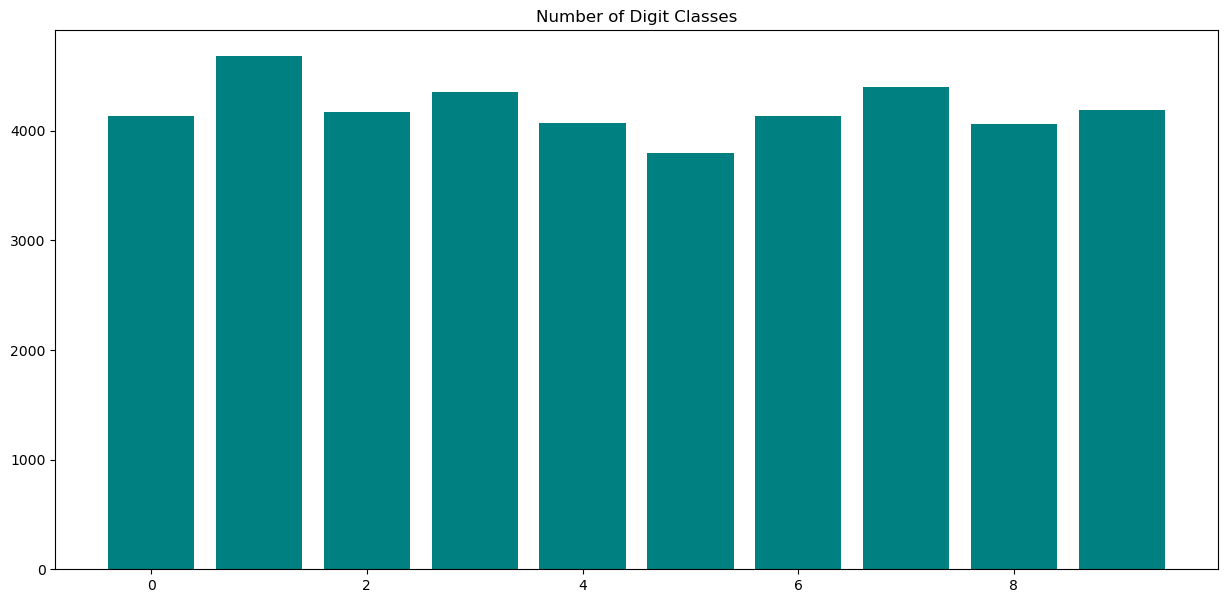

In [5]:
import matplotlib.pyplot as plt

# Visualize number of digit classes
plt.figure(figsize=(15, 7))
count = Y_train.value_counts()
plt.bar(count.index, count.values, color='teal')
plt.title('Number of Digit Classes')
plt.show()

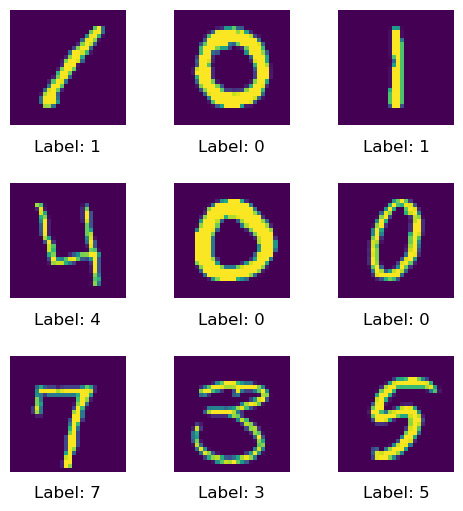

In [6]:
_,ax = plt.subplots(3,3,figsize=(6,6))



for i,( image,label) in enumerate(zip(X_train,Y_train)) :
    
    
    ax[i//3][i%3].imshow(image.squeeze())
    ax[i//3][i%3].axis('off')
    ax[i//3][i%3].set_title(f"Label: {label}",y=-0.3)
    if(i==8): break
plt.subplots_adjust(hspace=0.5)
plt.show()


# Preprocessing Steps for Image Classification using CNNs
## Normalization
Normalization is performed on the images to reduce the effect of illumination differences. Grayscale normalization is commonly used as it helps CNNs to work faster.

## Reshape
The input images are of size 28 x 28. Therefore, we reshape all the data to 28x28x1 3D matrices. Keras requires an extra dimension at the end, which corresponds to channels. As the images are grayscale, only one channel is used.

## Label Encoding
Label encoding is performed to encode the labels to one-hot vectors. For example, the label "2" is encoded as [0,0,1,0,0,0,0,0,0,0], and the label "4" is encoded as [0,0,0,0,1,0,0,0,0,0]. This allows us to use categorical cross-entropy as the loss function in our CNN mode

We will first normalize the data

In [7]:
X_train = X_train / 255.0
test = test / 255.0


Now we print and observe the shapes

In [8]:
print("Training images shape: ",X_train.shape)
print("Test images shape: ",test.shape)

Training images shape:  (42000, 28, 28, 1)
Test images shape:  (28000, 784)


Test images haven't been reshaped. We thus first reshape them

In [9]:
test = test.values.reshape(-1,28,28,1)


In [10]:
print("Training images shape: ",X_train.shape)
print("Test images shape: ",test.shape)

Training images shape:  (42000, 28, 28, 1)
Test images shape:  (28000, 28, 28, 1)


Now we perform one-hot encoding for the labels

In [11]:
from keras.utils.np_utils import to_categorical #Used for one-hot encoding
Y_train = to_categorical(Y_train, num_classes = 10)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso


# Train Test Split
 We will be splitting the data into training and testing set using sklearn's train_test_split function
* test split size is 10% while train split size is 90%.


In [12]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("Training images set shape",X_train.shape)
print("Testing images set shape",X_train.shape)
print("Training labels shape",Y_train.shape)
print("Validaation labels shape",Y_test.shape)

Training images set shape (37800, 28, 28, 1)
Testing images set shape (37800, 28, 28, 1)
Training labels shape (37800, 10)
Validaation labels shape (4200, 10)


# Convolutional Neural Network
Convolutional Neural Networks (CNNs) are a type of deep learning algorithm used for image classification and object detection. They are widely used in computer vision applications due to their ability to automatically learn and extract features from images. CNNs consist of a series of convolutional layers that apply filters to the input image, followed by pooling layers that downsample the output of the convolutional layers.

Here is an example of a CNN architecture for image classification:
* <a href="https://ibb.co/kV1j9p"><img src="https://preview.ibb.co/nRkBpp/gec2.jpg" alt="gec2" border="0"></a>

### Understanding Convolution Operation
Convolution operation is an essential technique used in convolutional neural networks (CNNs) for image classification. It involves using a feature detector/kernel/filter of a certain size (e.g., 3x3, 5x5, or 7x7) to detect specific features in an image, such as edges or shapes. The feature detector convolves or slides over the input image, performing element-wise multiplication of the corresponding pixel values. This results in a feature map or convolved feature that highlights the detected feature in the image. We use multiple feature detectors to create multiple feature maps, which are important for accurate classification. The stride is the number of steps that the feature detector takes while navigating over the input image. The size of the input image is reduced during convolution, which is useful for faster processing, but it also results in some loss of information.

 <a href="https://imgbb.com/"><img src="https://image.ibb.co/m4FQC9/gec.jpg" alt="gec" border="0"></a><br>
 After applying the convolutional layer, ReLU activation function is used to introduce non-linearity in the model. This helps in breaking the linearity of the image data and improving the model's ability to capture non-linear features in the image (as most of the data is non-linear in nature, we need to introduce back non-linearity)
 <br>
 <a href="https://ibb.co/mVZih9"><img src="https://preview.ibb.co/gbcQvU/RELU.jpg" alt="RELU" border="0"></a>

### Preserving the Image Dimensions (Padding)
CNNs use convolutions to extract features from images, and each convolution reduces the size of the input volume. Same padding is used in the early layers of a CNN to prevent this reduction in size and preserve important information about the original input, which helps to extract low-level features effectively. Essentially, same padding ensures that the output size of a convolutional layer is the same as the input size.
<br> <a href="https://ibb.co/jUPkUp"><img src="https://preview.ibb.co/noH5Up/padding.jpg" alt="padding" border="0"></a>


### Max Pooling
Max pooling is an essential component of Convolutional Neural Networks (CNNs) that helps in down-sampling or sub-sampling of the input image. This process helps to reduce the number of parameters in the network, which in turn helps control overfitting. Additionally, max pooling also makes the detection of features invariant to scale or orientation changes, which is crucial in image recognition tasks. By reducing the amount of parameters and computation required in the network, max pooling helps to improve the overall efficiency and accuracy of the model.

. 
<a href="https://ibb.co/ckTjN9"><img src="https://preview.ibb.co/gsNYFU/maxpool.jpg" alt="maxpool" border="0"></a>


### Flattening
During the flattening process, the spatial dimensions of the input volume are collapsed into a single dimension while preserving the total number of elements in the array. This operation is necessary because fully connected layers require a 1D input, while convolutional and pooling layers operate on 2D or 3D inputs.
<br> <a href="https://imgbb.com/"><img src="https://image.ibb.co/c7eVvU/flattenigng.jpg" alt="flattenigng" border="0"></a>


### Fully Connected Layer (FCC)
The fully connected layer (FCC) is a type of layer in a neural network where each neuron is connected to every neuron in the previous layer. This means that the FCC receives input from all the neurons in the previous layer
<br> <a href="https://ibb.co/hsS14p"><img src="https://preview.ibb.co/evzsAU/fullyc.jpg" alt="fullyc" border="0"></a>


# Implementing CNN Model

In [13]:
# 
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'same',  activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

#FCC Part
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


# Defining Optimizer & The Loss function   
We would be using Adam's Optimizer & Cateogorical Cross entropy loss function


Adam optimizer is an algorithm that dynamically adjusts the learning rate for each parameter in a neural network based on the estimates of the gradients. It helps improve the training process by efficiently updating the network parameters. While categorical crossentropy loss function is a loss function used to assess the accuracy of a machine learning model when dealing with multiple classes or categories. It quantifies how well the model's predicted probabilities align with the actual true labels.

In [14]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
#Now we compile the model

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


<a id="13"></a>



<a id="14"></a>
### Epochs and Batch Size
 An epoch refers to a complete iteration or pass through the entire dataset during the training of a machine learning model,ie. in this process, the model makes predictions on each data point, calculates the error, and updates its internal parameters to improve its performance.
 


In [15]:
epochs=10

In machine learning, we often process data in batches rather than all at once. Batch size refers to the number of data points or examples we process together in each batch during training. Instead of updating the model after seeing every single example, which could be time-consuming, we update it after processing a batch of examples.

In [16]:
batch_size = 32


# Data Augmentation
To address the issue of overfitting, it is important to increase the size of our handwritten digit dataset artificially. This can be achieved through a technique called data augmentation. Data augmentation involves applying small transformations to the training data in order to replicate the natural variations observed in handwritten digits<br>
<a href="https://ibb.co/k24CUp"><img src="https://preview.ibb.co/nMxXUp/augment.jpg" alt="augment" border="0"></a>
    


In [17]:
# Data augmentation
datagen = ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)


# Fitting The Model
When we talk about "fitting" a neural network, we are referring to the process of training the network on a given dataset. It involves iteratively adjusting the network's parameters (weights and biases) based on the input data and corresponding target values.

In [18]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size), epochs = epochs, validation_data = (X_test,Y_test))

Epoch 1/10


/tmp/ipykernel_23/3499739534.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size), epochs = epochs, validation_data = (X_test,Y_test))
2023-06-19 10:05:47.980799: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1182/1182 [==============================] - 21s 12ms/step - loss: 0.6788 - accuracy: 0.7745 - val_loss: 0.1188 - val_accuracy: 0.9671
Epoch 2/10
1182/1182 [==============================] - 15s 13ms/step - loss: 0.2785 - accuracy: 0.9129 - val_loss: 0.0863 - val_accuracy: 0.9740
Epoch 3/10
1182/1182 [==============================] - 15s 13ms/step - loss: 0.2209 - accuracy: 0.9309 - val_loss: 0.0644 - val_accuracy: 0.9795
Epoch 4/10
1182/1182 [==============================] - 15s 13ms/step - loss: 0.1893 - accuracy: 0.9421 - val_loss: 0.0566 - val_accuracy: 0.9843
Epoch 5/10
1182/1182 [==============================] - 15s 13ms/step - loss: 0.1758 - accuracy: 0.9457 - val_loss: 0.0558 - val_accuracy: 0.9826
Epoch 6/10
1182/1182 [==============================] - 15s 13ms/step - loss: 0.1571 - accuracy: 0.9525 - val_loss: 0.0456 - val_accuracy: 0.9857
Epoch 7/10
1182/1182 [==============================] - 15s 12ms/step - loss: 0.1499 - accuracy: 0.9547 - val_loss: 0.0466 - val_accura


# Evaluate model performance
We would visualizing the loss on the validation set as a function of number of epochs.
We will also plot a few sample predictions

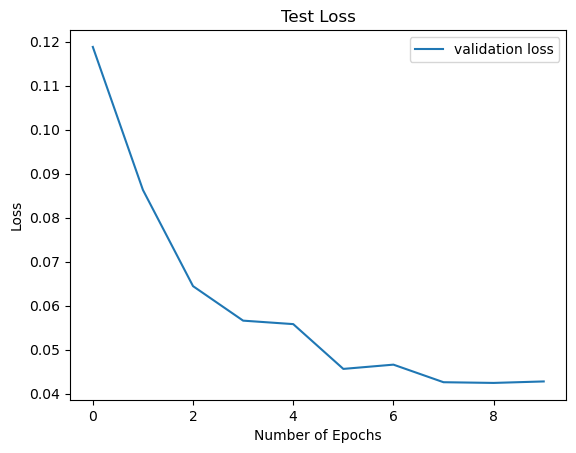

In [19]:

plt.plot(history.history['val_loss'], label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Now plotting a few sample predictions

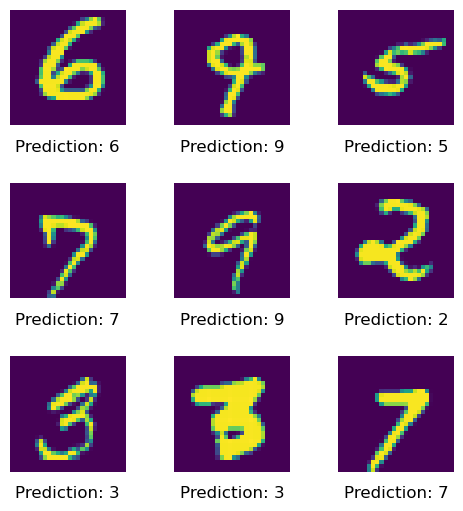

In [20]:
_,ax = plt.subplots(3,3,figsize=(6,6))
for i, image in enumerate(X_test):

    image = np.expand_dims(image,0)
    output = model(image)
    
    pred = np.argmax(output, axis=1, keepdims=True)
    
    ax[i//3][i%3].imshow(image.squeeze())
    ax[i//3][i%3].axis('off')
    ax[i//3][i%3].set_title(f"Prediction: {pred[0][0]}",y=-0.3)
    if(i==8): break
plt.subplots_adjust(hspace=0.5)
plt.show()

<hr>